In [21]:
using HybridSystems
include(joinpath(dirname(dirname(pathof(HybridSystems))), "examples", "cruise_control.jl"));

function constant(scaling)
    va = 15.6 * scaling
    v = (va,)
    U = 4.0 * scaling
    D = 0.5 * scaling
    vmin = 5.0 * scaling
    return D, U, vmin, v
end
D, U, vmin, v = constant(1.0)
const m0 = 500;
function system(M, T, h)
    N = 1 + (T+1) * length(v)
    return cruise_control_example(N, M, vmin = vmin, v=v, U=U, h=h, H=h*T, D=D, T=T, v_shift=-10.3, sym=false, m0 = m0, kd = 460);
end
Δv = (v[1] - vmin) / 2
# |string_elongation| < D
# |acceleration| < U
sym_rect(M) = [repeat([D, Δv], M); Δv; U]
const h = 0.4
const M = 1
const dim = 4
using SwitchOnSafety
const SOS = SwitchOnSafety
using JuMP
const MOI = JuMP.MOI;

In [20]:
for s in system(M, 1).resetmaps
    @show s.A
end

s.A = [1.0 -0.4 0.4 0.0; 1.8 0.816 0.184 0.0; 3.6 0.368 0.632 0.4; 0.0 0.0 0.0 0.0]
s.A = [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 0.0]


In [2]:
import Mosek
using MathOptInterfaceMosek
sdp_factory = with_optimizer(MosekOptimizer, QUIET=true);

In [12]:
using LightGraphs
const MOI = JuMP.MathOptInterface
function fullsolve(T, M, h, setvar::Function;
                   volume_heuristic=set -> L1_heuristic(set, sym_rect(M)),
                   oneshot = false,
                   onlyone = false)
    
    hs = system(M, T, h);
    function hv(v)
        h = zeros(statedim(hs, 1))
        for i in 1:M
            h[2i] = (vmin .+ v) / 2
        end
        h[2M+1] = (vmin .+ v) / 2
        h
    end
    habc = SOS.SetProg.InteriorPoint.(hv.(v))
    ha = habc[1]
    @assert nstates(hs) == 1 + (T+1) * length(v)
    hi = fill(ha, nstates(hs))
    set_variables = map(setvar, hi)
    if oneshot
        λ = Dict(t => 1.0 for t in transitions(hs))
    else
        λ = Dict(t => 1.0 for t in transitions(hs) if source(hs, t) == target(hs, t))
    end
    if oneshot
        return invariant_sets(hs, sdp_factory, set_variables, λ = λ, volume_heuristic=volume_heuristic);
    else
        sets = Vector{SwitchOnSafety.SetProg.Sets.AbstractSet{Float64}}(undef, length(ha))
        for i in (onlyone ? (1:1) : (1:N))
            invariant_sets!(sets, i:i, hs, sdp_factory, set_variables, λ = λ, enabled=1:i,
                            volume_heuristic=volume_heuristic, verbose=0)
        end
        return sets
    end
end

fullsolve (generic function with 1 method)

In [4]:
using JuMP
const MOI = JuMP.MOI

function mpcstep(hs, modes, x0, y0, soc, usetol)
    m = Model(sdp_factory)
    nt = length(modes)
    yvar = false
    if yvar
        y = @variable m [1:nt]
    else
        y = Vector{JuMP.AffExpr}(undef, nt)
    end
    xvar = false
    if xvar
        x = @variable m [1:nt, 1:dim]
    else
        x = Matrix{JuMP.AffExpr}(undef, nt, dim)
    end
    u = @variable m [1:(nt-1)]
    @show x0
    if x0 isa Vector
        if xvar
            cx0 = @constraint m x[1, :] .== x0
        else
            x[1, :] .= x0
        end
    else
        if xvar
            cx0 = @constraint m x[1, 2:3] .<= x0
        else
            @variable(m, x_0[1:4])
            cx0 = [@constraint(m, x_0[2] in MOI.LessThan(x0)),
                   @constraint(m, x_0[3] in MOI.LessThan(x0))]
            x[1, :] = x_0
        end
    end
    if yvar
        cy0 = @constraint m y[1] == y0
    else
        y[1] = y0
    end
    if usetol
        tol = @variable m lower_bound=0
    end
    cset = Vector{Any}(undef, nt)
    cdynx = Vector{Any}(undef, nt-1)
    cdyny = Vector{Any}(undef, nt-1)
    for i in 1:nt
        q = modes[i]
        @assert !Polyhedra.hashyperplanes(stateset(hs, q))
        if soc === nothing # || true
            for h in halfspaces(stateset(hs, q))
                # h.a[end] != 0 means that it is u <= 4 or u >= -4 for which we don't want to use tolerance
                # It is a hard constraint
                # Same for h.a[1] != 0
                # @constraint m dot(x[i, :], h.a) <= h.β + (usetol && iszero(h.a[1]) && iszero(h.a[end])? tol : 0.)
                @constraint m dot(x[i, :], h.a) <= h.β + (usetol ? tol : 0.)
            end
        end
        if soc !== nothing
            cset[i] = @constraint(m, x[i, :] in soc[q])
        end
        if i < nt
            s = modes[i+1]
            edge = LightGraphs.Edge(q, s)
            @assert 1 == length(hs.automaton.Σ[edge])
            t = HybridSystems.LightTransition(edge, first(keys(hs.automaton.Σ[edge])))
            σ = symbol(hs.automaton, t)
            r = hs.resetmaps[σ]
            if xvar
                cdynx[i] = @constraint m x[i+1, :] .== r.A * x[i, :] + r.B .* u[i]
            else
                x[i+1, :] = r.A * x[i, :] + r.B .* u[i]
            end
            if σ == 1
                if yvar
                    cdyny[i] = @constraint m y[i+1] == y[i] + h * x[i, dim-1]
                else
                    y[i+1] = y[i] + h * x[i, dim-1]
                end
            else
                if yvar
                    cdyny[i] = @constraint m y[i+1] == y[i]
                else
                    y[i+1] = y[i]
                end
            end
        end
    end
    @objective(m, Max, y[end] - (usetol ? 1000tol : 0.))
    println(m)
    JuMP.optimize!(m)
    @show JuMP.termination_status(m)
    @show JuMP.primal_status(m)
    @show JuMP.dual_status(m)

    feasible = JuMP.termination_status(m) != MOI.INFEASIBLE
    if feasible
        @assert JuMP.termination_status(m) == MOI.OPTIMAL || JuMP.termination_status(m) == MOI.SLOW_PROGRESS
        if JuMP.termination_status(m) == MOI.SLOW_PROGRESS
            @warn("Slow Progress")
        end
        if JuMP.primal_status(m) != MOI.FEASIBLE_POINT
            error("Primal Status: $(JuMP.primal_status(m))")
        end
    else
        @assert JuMP.dual_status(m) == MOI.INFEASIBILITY_CERTIFICATE
        #@show JuMP.dual.(cx0)
        #@show JuMP.dual(cy0)
        #@show JuMP.dual.(cset)
        #@show map(c -> JuMP.dual.(c), cdynx)
        #@show JuMP.dual.(cdyny)
    end
    feasible, JuMP.value.(x)[2:end,:], JuMP.value.(y)[2:end]
end

mpcstep (generic function with 1 method)

In [14]:
function solvempc(nt, nsteps, setvar::Union{Nothing, Function}=nothing; kws...)
    T = nsteps
    na = div(nt,2)-1
    nN = nt-T-na
    N = 1 + (T+1) * length(v)
    startstate = N
    modes = [fill(startstate, nN); collect((T+1):-1:2); fill(1, na)]
    @assert length(modes) == nt
    y = Vector{Float64}(undef, nt)
    x = Matrix{Float64}(undef, nt, dim)
    x[1, :] = [repeat([0., 10.], M); 10.; 0.]
    y[1] = -10. * h
    last = nt
    if setvar !== nothing
        #soc = elltosoc.(fullsolve(T, M, h, setvar, volume_heuristic=volume_heuristic,
        #                oneshot=false, onlyone=false))
        soc = fullsolve(T, M, h, setvar; oneshot=false, onlyone=false, kws...)
        soc = fill(soc[1], length(soc))
        #return soc
    else
        soc = nothing
    end
    hs = system(N, M, T, h)
    for i in 1:(nt-1)
        @show i
        j = min(nt, i + nsteps)
        _step(usetol) = mpcstep(hs, modes[i:j], i == 1 ? 16.0 : x[i, :], y[i], soc, usetol)
        feasible, X, Y = _step(false)
        @show feasible
        if !feasible
            feasible, X, Y = _step(true)
            @show feasible
        end
        while !feasible && nsteps > 1
            nsteps -= 1
            ds, X, Y = _step(true)
            @show nsteps
        end
        x[i+1, :] = X[1, :]
        y[i+1] = Y[1]
        if last == nt && (!feasible || !(X[1, :] in stateset(hs, modes[i+1])))
            @show X[1, :]
            @show stateset(hs, modes[i+1])
            last = i+1
            #break
        end
    end
    if last < nt
        @warn("$last < $nt")
    end
    take = last
    #take = nt
    if take > nN
        [x[2:nN, :]; x[(nN+2):take, :]], [y[2:nN]; y[(nN+2):take]]
    else
        x[2:take, :], y[2:take]
    end
end

solvempc (generic function with 2 methods)

In [6]:
nt = 15
#nt = 77
#nt = 152
tswitch = fill(h * (nt-2) / 2, 2)
t = [0.]
for i in 2:(nt-2)
    push!(t, t[end] + h)
end
minsafe = 3
#minsafe = 24

3

In [7]:
XYok = Dict{String, Tuple{Matrix{Float64}, Vector{Float64}}}()
XYko = Dict{String, Tuple{Matrix{Float64}, Vector{Float64}}}();

In [15]:
XYok["unsafe"] = solvempc(nt, minsafe-1)
#@assert 55 == XYok["unsafe"][2]

i = 1
x0 = 16.0
Max 0.4 x_0[3] - 4
Subject to
 x_0[2] ≤ 16.0
 x_0[3] ≤ 16.0
 -x_0[1] ≤ 0.5
 x_0[1] ≤ 0.5
 -x_0[4] ≤ 4.0
 x_0[4] ≤ 4.0
 -x_0[2] ≤ -5.0
 -x_0[3] ≤ -5.0
 x_0[2] ≤ 35.0
 x_0[3] ≤ 35.0
 -x_0[1] + 0.4 x_0[2] - 0.4 x_0[3] ≤ 0.5
 x_0[1] - 0.4 x_0[2] + 0.4 x_0[3] ≤ 0.5
 -noname ≤ 4.0
 noname ≤ 4.0
 -1.8 x_0[1] - 0.816 x_0[2] - 0.18400000000000002 x_0[3] ≤ -5.0
 -3.6 x_0[1] - 0.36800000000000005 x_0[2] - 0.6319999999999999 x_0[3] - 0.4 x_0[4] ≤ -5.0
 1.8 x_0[1] + 0.816 x_0[2] + 0.18400000000000002 x_0[3] ≤ 35.0
 3.6 x_0[1] + 0.36800000000000005 x_0[2] + 0.6319999999999999 x_0[3] + 0.4 x_0[4] ≤ 35.0

JuMP.termination_status(m) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
feasible = true
i = 2
x0 = [-0.5, 15.1, 12.6, -4.0]
Max 7.44
Subject to
 0 ≤ 0.0
 0 ≤ 1.0
 0 ≤ 0.0
 0 ≤ 8.0
 0 ≤ 10.1
 0 ≤ 7.6
 0 ≤ 19.9
 0 ≤ 22.4
 0 ≤ -1.0
 0 ≤ 2.0
 -noname ≤ 4.0
 noname ≤ 4.0
 0 ≤ 8.7


JuMP.termination_status(m) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
feasible = true
i = 9
x0 = [-9.60489, -28.2527, -33.0015, 42.0015]
Max -9.06332947120233
Subject to
 0 ≤ -9.104894791712766
 0 ≤ 10.104894791712766
 0 ≤ 46.00151357653254
 0 ≤ -38.00151357653254
 0 ≤ -33.252654016936674
 0 ≤ -38.00151357653254
 0 ≤ 63.252654016936674
 0 ≤ 68.00151357653255
 0 ≤ -11.004438615551113
 0 ≤ 12.004438615551113
 -noname ≤ 4.0
 noname ≤ 4.0
 0 ≤ -51.415254800985295
 0 ≤ -54.03094907815421
 0 ≤ 62.015254800985296
 0 ≤ 64.6309490781542

JuMP.termination_status(m) = INFEASIBLE::TerminationStatusCode = 2
JuMP.primal_status(m) = NO_SOLUTION::ResultStatusCode = 0
JuMP.dual_status(m) = INFEASIBILITY_CERTIFICATE::ResultStatusCode = 4
feasible = false
x0 = [-9.60489, -28.2527, -33.0015, 42.0015]
Max -1000 noname - 9.06332947120233
Subject to
 noname ≥ 0.0
 -noname ≤ -9.104894791712766
 -

┌ Warning: 3 < 15
└ @ Main In[14]:49


([-0.5 15.1 12.6 -4.0; -1.5 13.74 10.12 5.0], [2.4, 7.44])

In [10]:
XYok["ellipsoids"] = solvempc(nt, minsafe-1, h -> Ellipsoid(point=h), volume_heuristic=nth_root);

i = 1
x0 = 16.0
JuMP.termination_status(m) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
feasible = true
i = 2
x0 = [-0.0284157, 15.4517, 15.3783, -0.881604]
JuMP.termination_status(m) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
feasible = true
i = 3
x0 = [-0.0577774, 15.2655, 15.1935, -0.711897]
JuMP.termination_status(m) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
feasible = true
i = 4
x0 = [-0.0865784, 15.029, 14.9657, -0.465973]
JuMP.termination_status(m) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
feasible = true
i = 5
x0 = [-0.111901, 14.

In [8]:
sols_4 = solvempc(nt, minsafe-1, h -> PolySet(convex=true, degree=4, point=h));

In [10]:
sols_2 = solvempc(nt, minsafe-1, h -> Ellipsoid(point=h));

length(sols_2) = 4


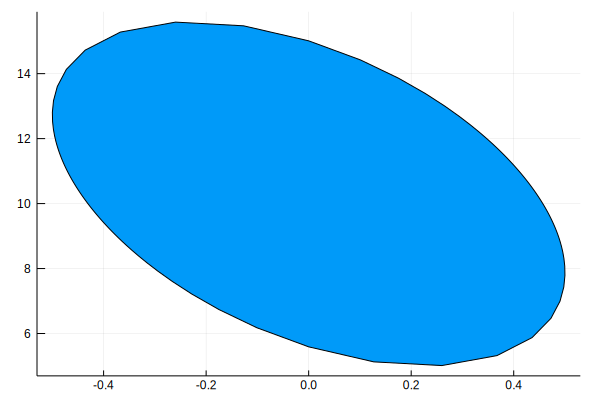

In [14]:
using Plots
@show length(sols_2)
plot(project(sols_2[1], [1, 3]), npoints=256)

length(sols_4) = 4


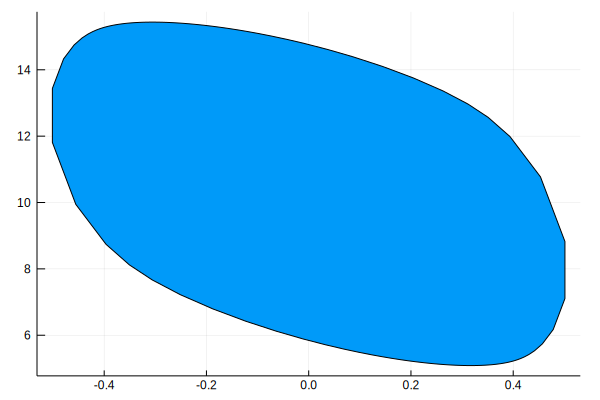

In [16]:
using Plots
@show length(sols_4)
plot(project(sols_4[1], [1, 3]), npoints=256)

In [11]:
XYok["ellipsoids tr"] = solvempc(nt, minsafe-1, h -> Ellipsoid(point=h));

i = 1
x0 = 16.0
JuMP.termination_status(m) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
feasible = true
i = 2
x0 = [-0.297553, 14.9883, 14.9486, 0.829699]
JuMP.termination_status(m) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
feasible = true
i = 3
x0 = [-0.313419, 14.3797, 14.3553, 1.11753]
JuMP.termination_status(m) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
feasible = true
i = 4
x0 = [-0.323195, 13.7706, 13.7639, 1.39247]
JuMP.termination_status(m) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
feasible = true
i = 5
x0 = [-0.325862, 13.1766, 1

In [12]:
XYok["quadratic"]  = solvempc(nt, minsafe-1, h -> PolySet(convex=true, degree=2, point=h));

i = 1
x0 = 16.0
JuMP.termination_status(m) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
feasible = true
i = 2
x0 = [-0.303244, 14.9811, 14.9435, 0.884336]
JuMP.termination_status(m) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
feasible = true
i = 3
x0 = [-0.318262, 14.3662, 14.3438, 1.16828]
JuMP.termination_status(m) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
feasible = true
i = 4
x0 = [-0.327225, 13.7521, 13.7478, 1.44236]
JuMP.termination_status(m) = OPTIMAL::TerminationStatusCode = 1
JuMP.primal_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
JuMP.dual_status(m) = FEASIBLE_POINT::ResultStatusCode = 1
feasible = true
i = 5
x0 = [-0.328934, 13.1552, 1

In [8]:
@show minsafe
minsafe=2
XYok["quartic"] = solvempc(nt, minsafe-1, h -> PolySet(convex=true, degree=4, point=h));

minsafe = 3
i = 1
x0 = 16.0
p = 1.38983858405033e-6x₁⁴ + 1.1081774063084456e-5x₁³x₂ - 1.3148415114507315e-5x₁³x₃ + 3.5783231245955516e-5x₁³x₄ + 3.8192799181311755e-5x₁²x₂² - 8.096111704936234e-5x₁²x₂x₃ + 0.00025856145953235144x₁²x₂x₄ + 5.099382615785127e-5x₁²x₃² - 0.0002973324945511162x₁²x₃x₄ + 0.0005303341599181793x₁²x₄² + 5.86533918619556e-5x₁x₂³ - 0.00018123330702575504x₁x₂²x₃ + 0.0005775291819254862x₁x₂²x₄ + 0.00020748931953899053x₁x₂x₃² - 0.0013120087004734472x₁x₂x₃x₄ + 0.00213145925802338x₁x₂x₄² - 8.967472870117702e-5x₁x₃³ + 0.0007837438380497582x₁x₃²x₄ - 0.0025262417651468116x₁x₃x₄² + 0.0023207388091025746x₁x₄³ + 3.519551841401939e-5x₂⁴ - 0.0001370003289045577x₂³x₃ + 0.00045589278110339166x₂³x₄ + 0.00022477033259899392x₂²x₃² - 0.0014298127196602252x₂²x₃x₄ + 0.002451918961735451x₂²x₄² - 0.0001800089702274689x₂x₃³ + 0.0016608340797511418x₂x₃²x₄ - 0.005183106887979289x₂x₃x₄² + 0.005536870614333404x₂x₄³ + 6.0450640861221945e-5x₃⁴ - 0.0007021346217865989x₃³x₄ + 0.00327299257101974x₃²


STALL
JuMP.termination_status(m) = SLOW_PROGRESS::TerminationStatusCode = 19
JuMP.primal_status(m) = UNKNOWN_RESULT_STATUS::ResultStatusCode = 6
JuMP.dual_status(m) = UNKNOWN_RESULT_STATUS::ResultStatusCode = 6
STALL
STALL
STALL
STALL


┌ Warning: Slow Progress
└ @ Main In[4]:101


ErrorException: Primal Status: UNKNOWN_RESULT_STATUS

In [16]:
import Plots
Plots.pyplot()
_savefig(name) = Plots.savefig("/home/blegat/Dropbox/Research/Images/CruiseControl$name.eps");
#XY = [("unsafe 8", XYko["unsafe 8"])];
XY = XYok;
plotsize = (800, 400);
# colors taken from https://previews.123rf.com/images/capacitorphoto/capacitorphoto1410/capacitorphoto141000191/32438941-Graph-Icon-color-set-illustration--Stock-Vector.jpg
red = Plots.RGBA(((0xf5, 0x92, 0x97) ./ 255)...)
gre = Plots.RGBA(((0xcb, 0xdf, 0x80) ./ 255)...)
blu = Plots.RGBA(((0x23, 0x94, 0xce) ./ 255)...)
ora = Plots.RGBA(((0xfa, 0xcb, 0x95) ./ 255)...)
yel = Plots.RGBA(((0xf2, 0xf0, 0x8b) ./ 255)...)
colors = Dict("unsafe" => ora, "ellipsoids" => blu, "ellipsoids tr" => red, "quadratic" => yel, "quartic" => gre);

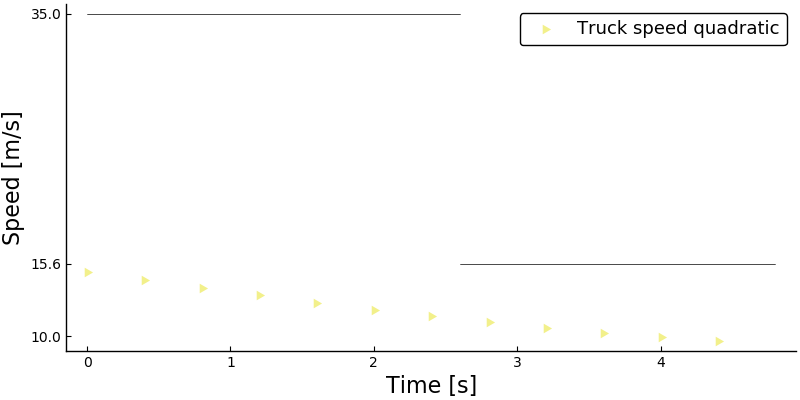

In [17]:
Plots.plot(legendfont=Plots.font(13), guidefont=Plots.font(16), tickfont=Plots.font(10), grid=false, yticks=[10, 15.6, 35], size=plotsize, xlabel="Time [s]", ylabel="Speed [m/s]")
Plots.plot!([t[1], tswitch[1]], [35, 35], linewidth=0.5, color=:black, label="")
Plots.plot!([tswitch[1], t[end]], [v[1], v[1]], linewidth=0.5, color=:black, label="")
mini = Inf
maxi = 35
for (s, (x, y)) in XY
    v1 = x[:,dim-2]
    v0 = x[:,dim-1]
    #:none,:auto,:circle,:rect,:star5,:diamond,:hexagon,:cross,:xcross,:utriangle,:dtriangle,:rtriangle,:ltriangle,:pentagon,:heptagon,:octagon,:star4,:star6,:star7,:star8,:vline,:hline,:+,:x].
    issafe = s[1] == 's'
    ms = 7 + (issafe ? 0 : 1)
    #Plots.scatter!(t[1:end-1], v1[1:end], label="Trailer speed $s", markersize=ms, markershape=issafe ? :diamond : :utriangle, markerstrokewidth=0)
    v0 = v0[1:end-1]
    Plots.scatter!(t[1:(length(v0))], v0, color = colors[s], label="Truck speed $s", markersize=ms, markershape=issafe ? :circle : :rtriangle, markerstrokewidth=0)
    mini = min(mini, minimum(v1), minimum(v0))
    maxi = max(maxi, maximum(v1), maximum(v0))
end
#Plots.plot!(tswitch, [mini, maxi])
#Plots.plot!(tswitch, [mini, maxi], linewidth=2, label="")
if length(XY) == 1
    #_savefig("UnsafeSpeed")
else
    #@assert length(XY) == 3
    #_savefig("Speed")
end
Plots.plot!()

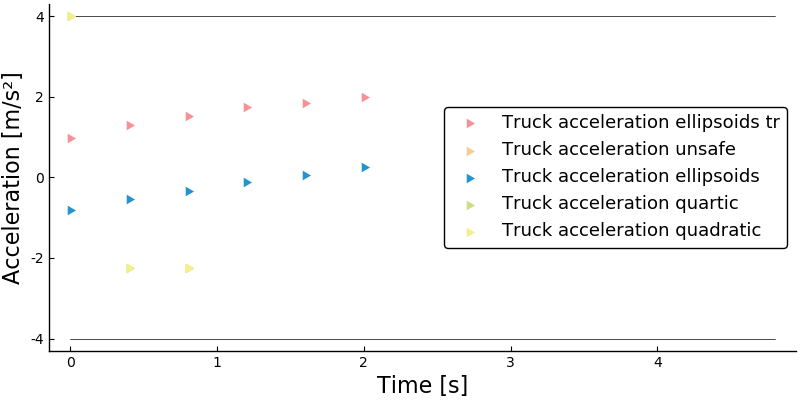

In [76]:
Plots.plot(legendfont=Plots.font(13), guidefont=Plots.font(16), tickfont=Plots.font(10), size=plotsize, grid=false, ylim=(-4.3, 4.3), xlabel="Time [s]", ylabel="Acceleration [m/s²]")
Plots.plot!([0, t[end]], [-4, -4], linewidth=0.5, color=:black, label="")
Plots.plot!([0, t[end]], [4, 4], linewidth=0.5, color=:black, label="")
for (s, (x, y)) in XY
    u = x[:, 4]
    issafe = s[1] == 's'
    u = u[1:end-2]
    ms = 7 + (issafe ? 0 : 1)
    if !issafe
        # Choose from :none,:auto,:circle,:rect,:star5,:diamond,:hexagon,:cross,:xcross,:utriangle,:dtriangle,:rtriangle,:ltriangle,:pentagon,:heptagon,:octagon,:star4,:star6,:star7,:star8,:vline,:hline,:+,:x].

        #Plots.scatter!([t[length(u)]], [u[end]], markersize=ms+5, markerstrokewidth=3, markershape=:circle, markercolor=:white, markerstrokecolor = red, label="Constraint violation for $s")
    end
    Plots.scatter!(t[1:length(u)], u, label="Truck acceleration $s", color = colors[s],
        markersize=ms, markershape=issafe ? :circle : :rtriangle, markerstrokewidth=0)
    Plots.scatter!()
end
#Plots.plot!(tswitch, [-U, U], label="")
if length(XY) == 1
    #_savefig("UnsafeAcceleration")
else
    #@assert length(XY) == 3
    #_savefig("Acceleration")
end
Plots.plot!()

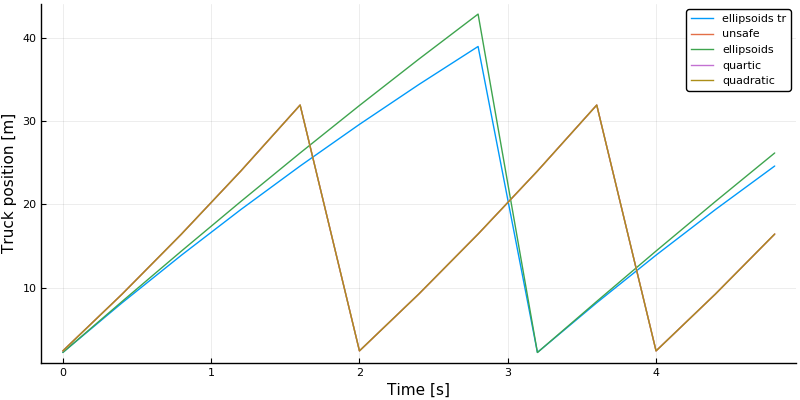

In [77]:
Plots.plot(size=(800, 400), xlabel="Time [s]", ylabel="Truck position [m]")
for (s, (x, y)) in XY
    Plots.plot!(t, y, label=s)
end
Plots.plot!()
#Plots.plot!(tswitch, collect(extrema(XY["unsafe optimal"][2])), label="")
#_savefig("Position")

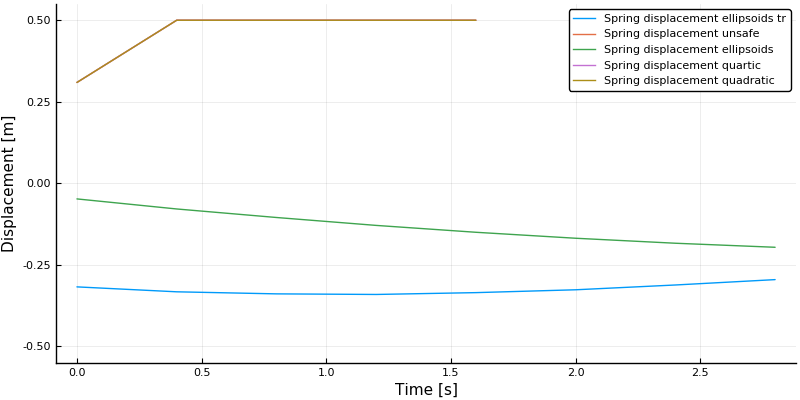

In [78]:
Plots.plot(yticks = [-0.5, -0.25, 0.0, 0.25, 0.5], ylims=(-0.55, 0.55), size=plotsize, xlabel="Time [s]", ylabel="Displacement [m]")
for (s, (x, y)) in XY
    dist = x[:, 1]
    Plots.plot!(t[1:length(dist)], dist, label="Spring displacement $s")
end
Plots.plot!()
#Plots.plot!(tswitch, [-.5, .5], label="")
#_savefig("Displacement")